(1, 6400, 4)
(40, 40, 4, 4)
The first anchor box at row 21, column 21: 
[0.38168523 0.25087047 0.6433147  0.7741295 ]
<NDArray 4 @cpu(0)>


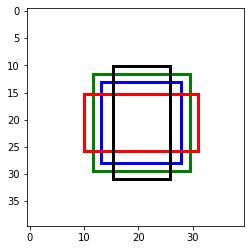

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, gluon
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.gluon import nn
import numpy as np
import os.path as osp

import mxnet.image as image

n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, 
                  sizes=[.2, .272],
                  ratios=[1, 2, .5])
    
y = MultiBoxPrior(x, 
                  sizes= [.37, .447],
                  ratios=[1, 2, .5])

print(y.shape)

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)
print('The first anchor box at row 21, column 21:', boxes[20, 20, 3, :])

#Showing generated boxes for 1 pixel

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [2]:
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

def toy_ssd_model(num_anchors, num_classes):
    downsamples = nn.Sequential()
    class_pred = nn.Sequential()
    box_pred = nn.Sequential()
    
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    
    for scale in range(5):
        class_pred.add(class_predictor(num_anchors, num_classes))
        box_pred.add(box_predictor(num_anchors))
        
    return body(), downsamples, class_pred, box_pred

def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    x = body(x)
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []
    
    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes = sizes[i], ratios = ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        
        if i < 3: x = downsamples[i](x)
        elif i == 3: x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))
            
    return default_anchors, predicted_classes, predicted_boxes


class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds
    
from mxnet.contrib.ndarray import MultiBoxTarget

def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target


class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)
    # cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
    
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./dataset/pikachu/pikachu_train.rec',
        path_imgidx='./dataset/pikachu/pikachu_train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./dataset/pikachu/pikachu_val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        print('Found hash mismatch in file {}, possibly due to incomplete download.'.format(file_path))
    return matched

def download_dataset():
    url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/{}'
    hashes = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
              'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
              'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in hashes.items():
        fname = 'pikachu_' + k
        target = osp.join('data', fname)
        url = url_format.format(k)
        if not osp.exists(target) or not verified(target, v):
            print('Downloading', target, url)
            download(url, fname=fname, dirname='data', overwrite=True)

def load_pretrain_params(net, epochs = 150):
    # LOAD PRE-TRAIN PARAMS ##################
    # set larger to get better performance
    
    log_interval = 20
    from_scratch = False  # set to True to train from scratch
    if from_scratch:
        start_epoch = 0
    else:
        start_epoch = 148
        pretrained = 'ssd_pretrained.params'
        sha1 = 'fbb7d872d76355fff1790d864c2238decdb452bc'
        url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/ssd_pikachu-fbb7d872.params'
        if not osp.exists(pretrained) or not verified(pretrained, sha1):
            print('Downloading', pretrained, url)
            download(url, fname=pretrained, overwrite=True)
        net.load_parameters(pretrained, ctx)
        
    return net, start_epoch, epochs


    

In [3]:
# # EXPERIMENTS ################################
# # a certain feature map with 20x20 spatial shape
# feat1 = nd.zeros((2, 8, 20, 20))
# print('Feature map 1', feat1.shape)
# cls_pred1 = class_predictor(5, 10)
# cls_pred1.initialize()
# y1 = cls_pred1(feat1)
# print('Class prediction for feature map 1', y1.shape)
# # down-sample
# ds = down_sample(16)
# ds.initialize()
# feat2 = ds(feat1)
# print('Feature map 2', feat2.shape)
# cls_pred2 = class_predictor(3, 10)
# cls_pred2.initialize()
# y2 = cls_pred2(feat2)
# print('Class prediction for feature map 2', y2.shape)
# flat_y1 = flatten_prediction(y1)
# print('Flatten class prediction 1', flat_y1.shape)
# flat_y2 = flatten_prediction(y2)
# print('Flatten class prediction 2', flat_y2.shape)
# print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)


# print("################################")
# # body, downsamples, class_pred, box_pred = toy_ssd_model(5,10)

# # print(body)
# # print("################################")
# # print(downsamples)
# # print("################################")
# # print(class_pred)
# # print("################################")
# # print(box_pred)
# # print("################################")

# net = ToySSD(2)
# net.initialize()
# x = nd.zeros((1, 3, 256, 256))
# default_anchors, class_predictions, box_predictions = net(x)
# print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

#Get the data iterators
# import mxnet.image as image
# data_shape = 256
# batch_size = 32

# train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)
# batch = train_data.next()
# print(batch)

# #Show an example to verify the data is loaded

# img = batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
# img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
# img += np.array([123, 117, 104])
# img = img.astype(np.uint8)  # use uint8 (0-255)
# # draw bounding boxes on image
# for label in batch.label[0][0].asnumpy():
#     if label[0] < 0:
#         break
#     print(label)
#     xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
#     rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
#     plt.gca().add_patch(rect)
# plt.imshow(img)
# plt.show()

In [ ]:
# EXECUTE THE TRAINING LOOP #####################
import time
from mxnet import autograd as ag

cls_loss = FocalLoss()
box_loss = SmoothL1Loss()

print(cls_loss)
print(box_loss)

cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE() 
ctx = mx.cpu()

data_shape = 256
batch_size = 32

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)

net = ToySSD(num_class)

net,start_epoch, epochs = load_pretrain_params(net)

net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

log_interval = 20

for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

# we can save the trained parameters to disk
net.save_parameters('ssd_%d.params' % epochs)


FocalLoss(batch_axis=0, w=None)
SmoothL1Loss(batch_axis=0, w=None)


/Users/nguyen/Desktop/python_workspace/datascience/env/lib/python3.6/site-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'toyssd1_conv16_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/nguyen/Desktop/python_workspace/datascience/env/lib/python3.6/site-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'toyssd1_conv16_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/nguyen/Desktop/python_workspace/datascience/env/lib/python3.6/site-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'toyssd1_batchnorm6_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Users/nguyen/Desktop/python_workspace/datascience/env/lib/python3.6/site-packages/mxnet/gluon/parameter.py:862: UserWar

[Epoch 148 Batch 19] speed: 12.171506 samples/s, training: accuracy=0.997540, mae=0.001827
